## Analyze A/B Test Results

## Table of Contents
- [Introduction](#intro)
- [Part I - Probability](#probability)
- [Part II - A/B Test](#ab_test)
- [Part III - Regression](#regression)


<a id='intro'></a>
### Introduction

A/B tests are very commonly performed by data analysts and data scientists. 

For this project, we will be working to understand the results of an A/B test run by an e-commerce website.  The goal is to work through this notebook to help the company understand if they should implement the new page, keep the old page, or perhaps run the experiment longer to make their decision.


<a id='probability'></a>
#### Part I - Probability

To get started, let's import our libraries.

In [2]:
pip install pandas

import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
%matplotlib inline
#We are setting the seed to assure you get the same answers on quizzes as we set up
random.seed(42)

SyntaxError: invalid syntax (<ipython-input-2-e7a85136e870>, line 1)

In [3]:
pipenv install pandas

SyntaxError: invalid syntax (<ipython-input-3-e336bb692662>, line 1)

`1.` Now, read in the `ab_data.csv` data. Store it in `df`.  

a. Read in the dataset and take a look at the top few rows here:

In [2]:
df = pd.read_csv('ab_data.csv')
df.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


b. Use the cell below to find the number of rows in the dataset.

In [3]:
df.shape

(294478, 5)

c. The number of unique users in the dataset.

In [4]:
df.nunique()

user_id         290584
timestamp       294478
group                2
landing_page         2
converted            2
dtype: int64

d. The proportion of users converted.

In [1]:
df.query('converted == "1"').user_id.nunique()/df.user_id.nunique().shape[0]

NameError: name 'df' is not defined

e. The number of times the `new_page` and `treatment` don't match.

In [6]:
df_treatment = df.query('group == "treatment"')
df_nomatch_treatment = df_treatment.query('landing_page == "old_page"')
df_nomatch_treatment['landing_page'].value_counts()
#comes out to be 1965

df_control = df.query('group == "control"')
df_nomatch_control = df_control.query('landing_page == "new_page"')
df_nomatch_control['landing_page'].value_counts()
#comes out to be 1928

#so total non matches = 1965+1928
#3893

new_page    1928
Name: landing_page, dtype: int64

f. Do any of the rows have missing values?

In [7]:
df.isnull().sum()

user_id         0
timestamp       0
group           0
landing_page    0
converted       0
dtype: int64

`2.` For the rows where **treatment** does not match with **new_page** or **control** does not match with **old_page**, we cannot be sure if this row truly received the new or old page. 

a. Create a new dataset that meets the specifications from the quiz.  Store your new dataframe in **df2**.

In [8]:
#we will remove the rows that do not match
df1 = df.drop(df[(df.group == "control") & (df.landing_page == "new_page")].index)
   
df2 = df1.drop(df1[(df1.group == "treatment") & (df1.landing_page == "old_page")].index)


df2.shape


(290585, 5)

In [139]:
# Double Check all of the correct rows were removed - this should be 0
df2[((df2['group'] == 'treatment') == (df2['landing_page'] == 'new_page')) == False].shape[0]

0

a. How many unique **user_id**s are in **df2**?

In [9]:
df2.user_id.nunique()

290584

b. There is one **user_id** repeated in **df2**.  What is it?

In [10]:
ids = df2['user_id']
df2[ids.isin(ids[ids.duplicated()])]
#the user_id which is duplicate is 773192

,user_id,timestamp,group,landing_page,converted
1899,773192,2017-01-09 05:37:58.781806,treatment,new_page,0
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


c. What is the row information for the repeat **user_id**? 

**We can see the row information above**

d. Remove **one** of the rows with a duplicate **user_id**, but keep your dataframe as **df2**.

In [11]:
df2.drop_duplicates('user_id', inplace=True)

a. What is the probability of an individual converting regardless of the page they receive?

In [12]:
df2['converted'].mean()

0.11959708724499628

b. Given that an individual was in the `control` group, what is the probability they converted?

In [13]:
df2_control = df2.query('group == "control"')
df2_control['converted'].mean()

0.1203863045004612

c. Given that an individual was in the `treatment` group, what is the probability they converted?

In [14]:
df2_treatment = df2.query('group == "treatment"')
df2_treatment['converted'].mean()

0.11880806551510564

d. What is the probability that an individual received the new page?

In [15]:
df2[df2['landing_page']=="new_page"].count()/df2['landing_page'].count()

user_id         0.500062
timestamp       0.500062
group           0.500062
landing_page    0.500062
converted       0.500062
dtype: float64

e. Consider your results from parts (a) through (d) above, and explain below whether you think there is sufficient evidence to conclude that the new treatment page leads to more conversions.

**Since the probability of recieving a new page is 50%, and probability of conversion regardless of page is 11.96%, it is almost same as when individual is in treatment group. Also there is not much of a difference in probabilty of converting when individual is in control group and in treatment group. Hence we cannot conclude from this that new treatment page leads to more conversions.**

<a id='ab_test'></a>
### Part II - A/B Test  

`1.` For now, consider you need to make the decision just based on all the data provided.  If you want to assume that the old page is better unless the new page proves to be definitely better at a Type I error rate of 5%, what should your null and alternative hypotheses be?  You can state your hypothesis in terms of words or in terms of **$p_{old}$** and **$p_{new}$**, which are the converted rates for the old and new pages.

- Null Hypothesis:
pold - pnew >= 0
- Alternate Hypothesis:
pnew - pold > 0

`2.` Assume under the null hypothesis, $p_{new}$ and $p_{old}$ both have "true" success rates equal to the **converted** success rate regardless of page - that is $p_{new}$ and $p_{old}$ are equal. Furthermore, assume they are equal to the **converted** rate in **ab_data.csv** regardless of the page. <br><br>

Use a sample size for each page equal to the ones in **ab_data.csv**.  <br><br>

Perform the sampling distribution for the difference in **converted** between the two pages over 10,000 iterations of calculating an estimate from the null.  <br><br>

a. What is the **conversion rate** for $p_{new}$ under the null? 

In [16]:
p_new = df2.converted.mean()
p_new

0.11959708724499628

b. What is the **conversion rate** for $p_{old}$ under the null? <br><br>

In [17]:
p_old = df2.converted.mean()
p_old

0.11959708724499628

c. What is $n_{new}$, the number of individuals in the treatment group?

In [18]:
n_new = len(df2_treatment.index)
n_new

145310

d. What is $n_{old}$, the number of individuals in the control group?

In [19]:
n_old = len(df2_control.index)
n_old

145274

e. Simulate $n_{new}$ transactions with a conversion rate of $p_{new}$ under the null.  Store these $n_{new}$ 1's and 0's in **new_page_converted**.

In [20]:
new_page_converted = np.random.choice([0, 1], size = n_new, p = [p_new, 1 - p_new])

f. Simulate $n_{old}$ transactions with a conversion rate of $p_{old}$ under the null.  Store these $n_{old}$ 1's and 0's in **old_page_converted**.

In [21]:
old_page_converted = np.random.choice([0, 1], size = n_old, p = [p_old, 1 - p_old])

g. Find $p_{new}$ - $p_{old}$ for your simulated values from part (e) and (f).

In [22]:

p_diff = new_page_converted.mean() - old_page_converted.mean()

p_diff

0.00074565756865319077

h. Create 10,000 $p_{new}$ - $p_{old}$ values using the same simulation process you used in parts (a) through (g) above. Store all 10,000 values in a NumPy array called **p_diffs**.

In [25]:
p_diffs = []

for _ in range(10000):
    new_page_converted = np.random.choice([0, 1], size = n_new, p = [p_new, 1 - p_new]).mean()
    old_page_converted = np.random.choice([0, 1], size = n_old, p = [p_old, 1 - p_old]).mean()
    p_diffs.append(new_page_converted - old_page_converted)



p_diffs = []

new_page_converted = np.random.binomial(n_new, p_new, 10000)/n_new
old_page_converted = np.random.binomial(n_old, p_old, 10000)/n_old
p_diffs.append(new_page_converted - old_page_converted)

i. Plot a histogram of the **p_diffs**.  Does this plot look like what you expected?

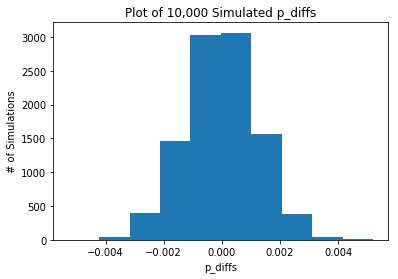

In [26]:

plt.hist(p_diffs);
plt.ylabel('# of Simulations')
plt.xlabel('p_diffs')
plt.title('Plot of 10,000 Simulated p_diffs');

**p_new - p_old is 0, since we are looking at a null where there is no difference in conversion based on the page**

j. What proportion of the **p_diffs** are greater than the actual difference observed in **ab_data.csv**?

In [28]:
#converting p_diffs into numpy array
p_diffs = np.array(p_diffs)

#computing actual difference observed in the dataset

act_diffs = df2.query('group == "treatment"').converted.mean() - df2.query('group == "control"').converted.mean()
act_diffs

-0.0015782389853555567

In [29]:
#computing the proportion of p_diffs greater than act_diff
(p_diffs > act_diffs).mean()

0.90149999999999997

k. Please explain using the vocabulary you've learned in this course what you just computed in part **j.**  What is this value called in scientific studies?  What does this value mean in terms of whether or not there is a difference between the new and old pages?


**We calculated the p-value which is the probability of getting our statistic or a more extreme value if the null is true.**

**Having a large p-value says that the statistic is more likely to come from our null hypothesis; hence, there is no statistical evidence to reject the null hypothesis which states that old pages are the same or slightly better than the new pages.**

l. We could also use a built-in to achieve similar results.  Though using the built-in might be easier to code, the above portions are a walkthrough of the ideas that are critical to correctly thinking about statistical significance. Fill in the below to calculate the number of conversions for each page, as well as the number of individuals who received each page. Let `n_old` and `n_new` refer the the number of rows associated with the old page and new pages, respectively.

In [30]:
import statsmodels.api as sm

convert_old = df2.query('group == "control"').converted.sum()
convert_new = df2.query('group == "treatment"').converted.sum()
n_old = df2.query("landing_page == 'old_page'").shape[0]
n_new = df2.query("landing_page == 'new_page'").shape[0]

/opt/conda/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


m. Now use `stats.proportions_ztest` to compute your test statistic and p-value.  [Here](https://docs.w3cub.com/statsmodels/generated/statsmodels.stats.proportion.proportions_ztest/) is a helpful link on using the built in.

In [31]:
z_score, p_value = sm.stats.proportions_ztest([convert_old, convert_new], [n_old, n_new], alternative='smaller')
z_score, p_value

(1.3109241984234394, 0.90505831275902449)

In [32]:
#computing significance of z-score
from scipy.stats import norm

norm.cdf(z_score)

0.90505831275902449

In [33]:
#checking critical value at 95% confidence interval
norm.ppf(1-(0.05/2))

1.959963984540054

n. What do the z-score and p-value you computed in the previous question mean for the conversion rates of the old and new pages?  Do they agree with the findings in parts **j.** and **k.**?

**From above, we have a z_score of 1.31. Since this value does not exceed the critical value at 95% confidence interval (1.96); there is no statistical evidence to reject the null hypothesis. Also, p-value obtained is similar to the result obtained from our previous findings in j. and k. which also fails to reject the null hypothesis as it provides evidence of a higher probability of the null hypothesis**

<a id='regression'></a>
### Part III - A regression approach

`1.` In this final part, you will see that the result you achieved in the A/B test in Part II above can also be achieved by performing regression.<br><br> 

a. Since each row is either a conversion or no conversion, what type of regression should you be performing in this case?

**Logistic Regression**

b. The goal is to use **statsmodels** to fit the regression model you specified in part **a.** to see if there is a significant difference in conversion based on which page a customer receives. However, you first need to create in df2 a column for the intercept, and create a dummy variable column for which page each user received.  Add an **intercept** column, as well as an **ab_page** column, which is 1 when an individual receives the **treatment** and 0 if **control**.

In [34]:
df2['intercept'] = 1
df2[['ab_page2', 'ab_page']] = pd.get_dummies(df2['group'])
df2 = df2.drop('ab_page2', axis = 1)
df2.head()

,user_id,timestamp,group,landing_page,converted,intercept,ab_page
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,1,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,1,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,1
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,1
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,1,0


c. Use **statsmodels** to instantiate your regression model on the two columns you created in part b., then fit the model using the two columns you created in part **b.** to predict whether or not an individual converts. 

In [35]:
log_mod = sm.Logit(df2['converted'], df2[['intercept', 'ab_page']])

d. Provide the summary of your model below, and use it as necessary to answer the following questions.

In [36]:
results = log_mod.fit()
results.summary2()

Optimization terminated successfully.
         Current function value: 0.366118
         Iterations 6


<class 'statsmodels.iolib.summary2.Summary'>
"""
                          Results: Logit
==================================================================
Model:              Logit            No. Iterations:   6.0000     
Dependent Variable: converted        Pseudo R-squared: 0.000      
Date:               2020-05-10 20:50 AIC:              212780.3502
No. Observations:   290584           BIC:              212801.5095
Df Model:           1                Log-Likelihood:   -1.0639e+05
Df Residuals:       290582           LL-Null:          -1.0639e+05
Converged:          1.0000           Scale:            1.0000     
-------------------------------------------------------------------
              Coef.   Std.Err.      z      P>|z|    [0.025   0.975]
-------------------------------------------------------------------
intercept    -1.9888    0.0081  -246.6690  0.0000  -2.0046  -1.9730
ab_page      -0.0150    0.0114    -1.3109  0.1899  -0.0374   0.0074
==================================================================

"""

e. What is the p-value associated with **ab_page**? Why does it differ from the value you found in **Part II**?<br><br>

**The p-value associated with ab_page was 0.19 which was significantly lower than the one in Part II which was approximately 0.9. The reason for such a significant difference is because the null and alternative hypothes is different in both cases.**

- Previous case
- H0: pold - pnew >= 0
- H1: pnew - pold > 0

- Current Case:
- H0: pold = pnew
- H1: pold != pnew


pold and pnew are the converted rates for the old and new pages respectively.

**Because the current case relies solely on two possible outcomes, it may be the reason that it yields a lower probability in the null hypothesis than that in the previous case.**


f. Now, you are considering other things that might influence whether or not an individual converts.  Discuss why it is a good idea to consider other factors to add into your regression model.  Are there any disadvantages to adding additional terms into your regression model?

**Advantages of adding other factors to the regression model**

- Allows for a more sophisticated model to distinguish other factors which may contribute to the outcome.
- May be used to identify outliers.

**Disadvantages of adding other factors to the regression model**
- May produce inaccurate results due to correlated errors.

g. Now along with testing if the conversion rate changes for different pages, also add an effect based on which country a user lives in. You will need to read in the **countries.csv** dataset and merge together your datasets on the appropriate rows.  [Here](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.join.html) are the docs for joining tables. 

Does it appear that country had an impact on conversion?  Don't forget to create dummy variables for these country columns - **Hint: You will need two columns for the three dummy variables.** Provide the statistical output as well as a written response to answer this question.

In [37]:
countries_df = pd.read_csv('countries.csv')
df_new = countries_df.set_index('user_id').join(df2.set_index('user_id'), how='inner')
df_new.head()

,country,timestamp,group,landing_page,converted,intercept,ab_page
user_id,,,,,,,
834778,UK,2017-01-14 23:08:43.304998,control,old_page,0,1,0
928468,US,2017-01-23 14:44:16.387854,treatment,new_page,0,1,1
822059,UK,2017-01-16 14:04:14.719771,treatment,new_page,1,1,1
711597,UK,2017-01-22 03:14:24.763511,control,old_page,0,1,0
710616,UK,2017-01-16 13:14:44.000513,treatment,new_page,0,1,1


In [168]:
#checking number of unique rows under country column

df_new.country.unique()

array(['US', 'UK', 'CA'], dtype=object)

In [39]:
#considering there are 3 dummy variables, we will include 2 columns

df_new[['UK', 'US']] = pd.get_dummies(df_new['country'])[['UK','US']]
df_new.head()

,country,timestamp,group,landing_page,converted,intercept,ab_page,UK,US
user_id,,,,,,,,,
834778,UK,2017-01-14 23:08:43.304998,control,old_page,0,1,0,1,0
928468,US,2017-01-23 14:44:16.387854,treatment,new_page,0,1,1,0,1
822059,UK,2017-01-16 14:04:14.719771,treatment,new_page,1,1,1,1,0
711597,UK,2017-01-22 03:14:24.763511,control,old_page,0,1,0,1,0
710616,UK,2017-01-16 13:14:44.000513,treatment,new_page,0,1,1,1,0


In [40]:
#computing the statistical output

log_mod = sm.Logit(df_new['converted'], df_new[['intercept', 'UK', 'US']])

In [41]:

results = log_mod.fit()
results.summary2()

Optimization terminated successfully.
         Current function value: 0.366116
         Iterations 6


<class 'statsmodels.iolib.summary2.Summary'>
"""
                          Results: Logit
==================================================================
Model:              Logit            No. Iterations:   6.0000     
Dependent Variable: converted        Pseudo R-squared: 0.000      
Date:               2020-05-10 20:50 AIC:              212780.8333
No. Observations:   290584           BIC:              212812.5723
Df Model:           2                Log-Likelihood:   -1.0639e+05
Df Residuals:       290581           LL-Null:          -1.0639e+05
Converged:          1.0000           Scale:            1.0000     
-------------------------------------------------------------------
               Coef.   Std.Err.     z      P>|z|    [0.025   0.975]
-------------------------------------------------------------------
intercept     -2.0375    0.0260  -78.3639  0.0000  -2.0885  -1.9866
UK             0.0507    0.0284    1.7863  0.0740  -0.0049   0.1064
US             0.0408    0.0269    1.5178  0.1291  -0.0119   0.0935
==================================================================

"""

**According to our statistical output the p-value for both countries yields a value larger than 0.05; hence, there is no statistical evidence on country's significant impact on conversion.**

h. Though you have now looked at the individual factors of country and page on conversion, we would now like to look at an interaction between page and country to see if there significant effects on conversion.  Create the necessary additional columns, and fit the new model.  

In [42]:
df_new['UK_new'] = df_new['UK'] * df_new['ab_page']
df_new['US_new'] = df_new['US'] * df_new['ab_page']

In [43]:
log_mod = sm.Logit(df_new['converted'], df_new[['intercept', 'UK', 'US', 'ab_page', 'UK_new', 'US_new']])

In [44]:
results = log_mod.fit()
results.summary2()

Optimization terminated successfully.
         Current function value: 0.366109
         Iterations 6


<class 'statsmodels.iolib.summary2.Summary'>
"""
                          Results: Logit
==================================================================
Model:              Logit            No. Iterations:   6.0000     
Dependent Variable: converted        Pseudo R-squared: 0.000      
Date:               2020-05-10 20:51 AIC:              212782.6602
No. Observations:   290584           BIC:              212846.1381
Df Model:           5                Log-Likelihood:   -1.0639e+05
Df Residuals:       290578           LL-Null:          -1.0639e+05
Converged:          1.0000           Scale:            1.0000     
-------------------------------------------------------------------
               Coef.   Std.Err.     z      P>|z|    [0.025   0.975]
-------------------------------------------------------------------
intercept     -2.0040    0.0364  -55.0077  0.0000  -2.0754  -1.9326
UK             0.0118    0.0398    0.2957  0.7674  -0.0663   0.0899
US             0.0175    0.0377    0.4652  0.6418  -0.0563   0.0914
ab_page       -0.0674    0.0520   -1.2967  0.1947  -0.1694   0.0345
UK_new         0.0783    0.0568    1.3783  0.1681  -0.0330   0.1896
US_new         0.0469    0.0538    0.8718  0.3833  -0.0585   0.1523
==================================================================

"""


**According to results above, after looking at interaction between page and country, there does not seem to be any statistical evidence to indicate an impact on the conversion since p-values are all exceeding 0.05.**

In [45]:
from subprocess import call
call(['python', '-m', 'nbconvert', 'Analyze_ab_test_results_notebook.ipynb'])

0